## 1. Pendahuluan

**Recurrent Neural Networks (RNNs)** adalah neural networks yang dirancang untuk **sequential data**.

### Contoh Sequential Data:
- 📈 Time series (stock prices, weather, sensor data)
- 📝 Text (sentences, documents)
- 🎵 Audio (speech, music)
- 🎬 Video (sequence of frames)

### Mengapa Butuh RNN?

**Feedforward networks** tidak cocok untuk sequences:
- ❌ Fixed input size
- ❌ Tidak ada memory dari input sebelumnya
- ❌ Tidak bisa handle variable-length sequences

**RNN** memiliki:
- ✅ **Memory** (hidden state)
- ✅ Variable-length input/output
- ✅ Parameter sharing across time steps

In [12]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Set random seed
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.20.0


## 2. Recurrent Neurons dan Layers

### 2.1 Basic RNN Cell

**Recurrent Neuron** memiliki connection ke dirinya sendiri (feedback loop).

**Formula:**
$$
h_t = \tanh(W_x \cdot x_t + W_h \cdot h_{t-1} + b)
$$

Dimana:
- $h_t$ = hidden state di time step $t$
- $x_t$ = input di time step $t$
- $h_{t-1}$ = hidden state sebelumnya
- $W_x$, $W_h$ = weight matrices
- $b$ = bias

In [13]:
# Visualisasi RNN unrolled through time
print("""
RNN Unrolled Through Time:

     h₀        h₁        h₂        h₃
      ↓         ↓         ↓         ↓
    ┌───┐     ┌───┐     ┌───┐     ┌───┐
h₋₁→│RNN│→h₀→│RNN│→h₁→│RNN│→h₂→│RNN│→h₃
    └───┘     └───┘     └───┘     └───┘
      ↑         ↑         ↑         ↑
     x₀        x₁        x₂        x₃

Same weights are shared across all time steps!
""")


RNN Unrolled Through Time:

     h₀        h₁        h₂        h₃
      ↓         ↓         ↓         ↓
    ┌───┐     ┌───┐     ┌───┐     ┌───┐
h₋₁→│RNN│→h₀→│RNN│→h₁→│RNN│→h₂→│RNN│→h₃
    └───┘     └───┘     └───┘     └───┘
      ↑         ↑         ↑         ↑
     x₀        x₁        x₂        x₃

Same weights are shared across all time steps!



### 2.2 RNN Types

| Type | Input | Output | Use Case |
|------|-------|--------|----------|
| **Sequence-to-Sequence** | Sequence | Sequence (same length) | Time series forecasting |
| **Sequence-to-Vector** | Sequence | Single vector | Sentiment analysis |
| **Vector-to-Sequence** | Single vector | Sequence | Image captioning |
| **Encoder-Decoder** | Sequence | Sequence (different length) | Translation |

In [14]:
# Simple RNN layer di Keras
simple_rnn = layers.SimpleRNN(
    units=32,              # Number of neurons (hidden state size)
    return_sequences=True,  # Return output at each time step
    return_state=False,     # Don't return final hidden state separately
    activation='tanh'
)

# Test dengan dummy input: (batch_size, time_steps, features)
dummy_input = tf.random.normal([4, 10, 5])  # 4 samples, 10 time steps, 5 features
output = simple_rnn(dummy_input)

print(f"Input shape:  {dummy_input.shape}  (batch, time_steps, features)")
print(f"Output shape: {output.shape}  (batch, time_steps, units)")

Input shape:  (4, 10, 5)  (batch, time_steps, features)
Output shape: (4, 10, 32)  (batch, time_steps, units)


In [15]:
# return_sequences=False → hanya output terakhir
rnn_last_output = layers.SimpleRNN(units=32, return_sequences=False)
output_last = rnn_last_output(dummy_input)

print(f"Input shape:  {dummy_input.shape}")
print(f"Output shape (return_sequences=False): {output_last.shape}")
print("\n→ Only returns the output from the last time step")

Input shape:  (4, 10, 5)
Output shape (return_sequences=False): (4, 32)

→ Only returns the output from the last time step


### 2.3 Stacking RNN Layers

In [16]:
# Stacked RNN (Deep RNN)
model = keras.Sequential([
    layers.SimpleRNN(32, return_sequences=True, input_shape=(None, 5)),
    layers.SimpleRNN(32, return_sequences=True),
    layers.SimpleRNN(32, return_sequences=False),  # Last layer
    layers.Dense(1)
])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_7 (SimpleRNN)        │ (None, None, 32)       │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_8 (SimpleRNN)        │ (None, None, 32)       │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_9 (SimpleRNN)        │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,409 (21.13 KB)

 Trainable params: 5,409 (21.13 KB)

 Non-trainable params: 0 (0.00 B)

## 3. Training RNNs

### 3.1 Backpropagation Through Time (BPTT)

RNN di-train menggunakan **BPTT**:
1. Unroll RNN through all time steps
2. Forward pass untuk semua time steps
3. Compute loss di setiap output
4. Backward pass (gradients flow through time)
5. Update weights

**Masalah:**
- **Vanishing gradients**: Gradient → 0 untuk long sequences
- **Exploding gradients**: Gradient → ∞

In [17]:
# Gradient clipping untuk mengatasi exploding gradients
optimizer = keras.optimizers.Adam(clipnorm=1.0)  # Clip gradient norm

# Atau clip by value
optimizer_clip_value = keras.optimizers.Adam(clipvalue=0.5)

print("Gradient Clipping Options:")
print("- clipnorm: Clip gradient if its norm exceeds threshold")
print("- clipvalue: Clip gradient values to [-threshold, threshold]")

Gradient Clipping Options:
- clipnorm: Clip gradient if its norm exceeds threshold
- clipvalue: Clip gradient values to [-threshold, threshold]


## 4. Forecasting Time Series

### 4.1 Generate Synthetic Time Series

In [18]:
# Generate synthetic time series data
def generate_time_series(batch_size, n_steps):
    """Generate batch of time series with trend, seasonality, and noise"""
    freq1, freq2 = np.random.uniform(0.1, 0.3, 2)
    offset1, offset2 = np.random.uniform(0, 2*np.pi, 2)
    
    time = np.arange(n_steps)
    series = np.zeros((batch_size, n_steps, 1))
    
    for i in range(batch_size):
        trend = 0.1 * time  # Linear trend
        seasonality = 2 * np.sin(freq1 * time + offset1) + np.sin(freq2 * time + offset2)
        noise = np.random.randn(n_steps) * 0.5
        series[i, :, 0] = trend + seasonality + noise
    
    return series.astype(np.float32)

# Generate data
n_steps = 50
series = generate_time_series(10000, n_steps + 1)

# Split into train/val/test
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

print(f"Training set:   X={X_train.shape}, y={y_train.shape}")
print(f"Validation set: X={X_valid.shape}, y={y_valid.shape}")
print(f"Test set:       X={X_test.shape}, y={y_test.shape}")

Training set:   X=(7000, 50, 1), y=(7000, 1)
Validation set: X=(2000, 50, 1), y=(2000, 1)
Test set:       X=(1000, 50, 1), y=(1000, 1)


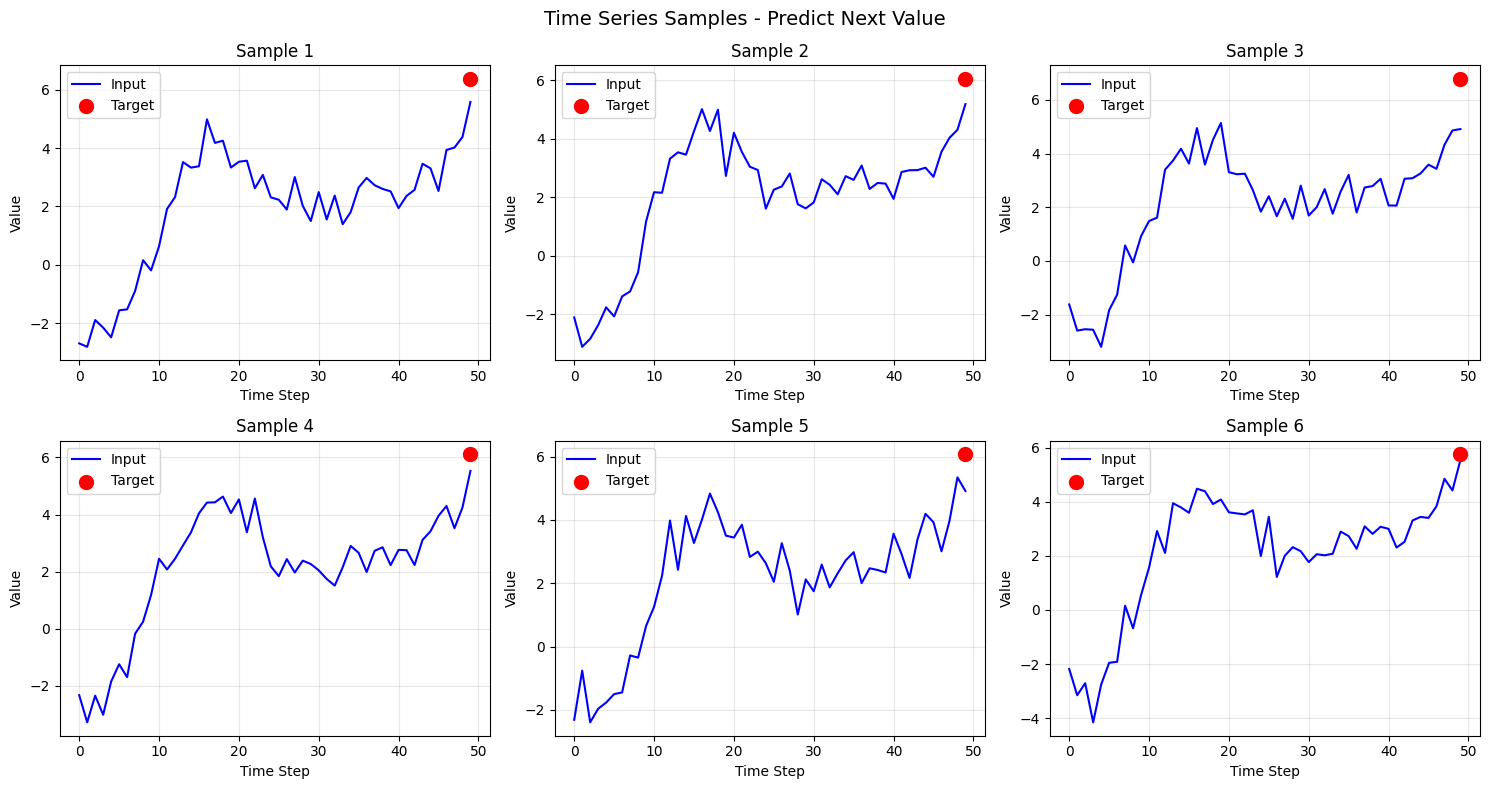

In [19]:
# Visualize sample time series
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

for i, ax in enumerate(axes.flat):
    ax.plot(X_train[i, :, 0], 'b-', label='Input')
    ax.scatter([n_steps-1], [y_train[i, 0]], color='red', s=100, 
               zorder=5, label='Target')
    ax.set_xlabel('Time Step')
    ax.set_ylabel('Value')
    ax.set_title(f'Sample {i+1}')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle('Time Series Samples - Predict Next Value', fontsize=14)
plt.tight_layout()
plt.show()

### 4.2 Baseline Models

In [20]:
# Baseline 1: Naive forecast (predict last value)
y_pred_naive = X_valid[:, -1]  # Last time step as prediction
mse_naive = np.mean((y_valid - y_pred_naive) ** 2)

print(f"Naive Baseline MSE: {mse_naive:.4f}")

Naive Baseline MSE: 0.8727


In [21]:
# Baseline 2: Linear regression
model_linear = keras.Sequential([
    layers.Flatten(input_shape=[n_steps, 1]),
    layers.Dense(1)
])

model_linear.compile(optimizer='adam', loss='mse')
model_linear.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid), verbose=0)

mse_linear = model_linear.evaluate(X_valid, y_valid, verbose=0)
print(f"Linear Model MSE: {mse_linear:.4f}")

Linear Model MSE: 0.6332


### 4.3 Simple RNN Model

In [22]:
# Simple RNN untuk time series forecasting
model_rnn = keras.Sequential([
    layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    layers.SimpleRNN(20),
    layers.Dense(1)
])

model_rnn.compile(optimizer='adam', loss='mse')
model_rnn.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_10 (SimpleRNN)       │ (None, None, 20)       │           440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_11 (SimpleRNN)       │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,281 (5.00 KB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# Train
history = model_rnn.fit(
    X_train, y_train,
    epochs=20,
    validation_data=(X_valid, y_valid),
    callbacks=[keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)],
    verbose=1
)

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 3.1879 - val_loss: 0.2539
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.2516 - val_loss: 0.2531
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.2516 - val_loss: 0.2530
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.2516 - val_loss: 0.2530
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.2516 - val_loss: 0.2529
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.2517 - val_loss: 0.2529
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.2517 - val_loss: 0.2529
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.2518 - val_loss: 0.2529
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.2518 - val_loss: 0.2529
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.2519 - val_loss: 0.2528
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.2520 - val_loss: 0.2528
Epoch 12/20
219/219 ━━━━━━━━━━━━━━━━━━━━

In [24]:
# Evaluate
mse_rnn = model_rnn.evaluate(X_valid, y_valid, verbose=0)

print("\n=== Model Comparison ===")
print(f"Naive Baseline MSE: {mse_naive:.4f}")
print(f"Linear Model MSE:   {mse_linear:.4f}")
print(f"Simple RNN MSE:     {mse_rnn:.4f}")


=== Model Comparison ===
Naive Baseline MSE: 0.8727
Linear Model MSE:   0.6332
Simple RNN MSE:     0.2528


### 4.4 Sequence-to-Sequence Forecasting

In [25]:
# Prepare data untuk seq2seq (predict next value at each time step)
Y_train_seq = np.concatenate([X_train[:, 1:], y_train[:, np.newaxis, :]], axis=1)
Y_valid_seq = np.concatenate([X_valid[:, 1:], y_valid[:, np.newaxis, :]], axis=1)

print(f"Input shape:  {X_train.shape}")
print(f"Target shape: {Y_train_seq.shape}")
print("\nAt each time step, predict the next value")

Input shape:  (7000, 50, 1)
Target shape: (7000, 50, 1)

At each time step, predict the next value


In [26]:
# Sequence-to-Sequence RNN
model_seq2seq = keras.Sequential([
    layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    layers.SimpleRNN(20, return_sequences=True),
    layers.Dense(1)  # Applied at each time step (TimeDistributed)
])

model_seq2seq.compile(optimizer='adam', loss='mse')
model_seq2seq.fit(
    X_train, Y_train_seq,
    epochs=20,
    validation_data=(X_valid, Y_valid_seq),
    callbacks=[keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)],
    verbose=1
)

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 1.5443 - val_loss: 0.5116
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.4336 - val_loss: 0.3639
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.3361 - val_loss: 0.3142
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.3000 - val_loss: 0.3231
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.2841 - val_loss: 0.2764
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.2740 - val_loss: 0.2696
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.2690 - val_loss: 0.2661
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.2657 - val_loss: 0.2643
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.2634 - val_loss: 0.2628
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 0.2618 - val_loss: 0.2615
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.2605 - val_loss: 0.2603
Epoch 12/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4

## 5. Handling Long Sequences

### 5.1 Vanishing Gradient Problem

**Problem:** Untuk long sequences, gradient mengecil exponentially.

$$
\frac{\partial h_T}{\partial h_1} = \prod_{t=2}^{T} \frac{\partial h_t}{\partial h_{t-1}}
$$

Jika derivatives < 1, product → 0 (vanishing)
Jika derivatives > 1, product → ∞ (exploding)

**Solutions:**
1. **Gradient Clipping** - untuk exploding gradients
2. **LSTM / GRU** - gated architectures
3. **Layer Normalization** - stabilize activations

In [27]:
# Demonstrasi vanishing gradient
print("""
Vanishing Gradient Example:

Jika setiap ∂hₜ/∂hₜ₋₁ ≈ 0.9 (typical dengan tanh):

- After 10 steps:  0.9¹⁰  = 0.35
- After 50 steps:  0.9⁵⁰  = 0.005
- After 100 steps: 0.9¹⁰⁰ = 0.00003

→ Gradient hampir hilang untuk early time steps!
→ RNN tidak bisa learn long-term dependencies
""")


Vanishing Gradient Example:

Jika setiap ∂hₜ/∂hₜ₋₁ ≈ 0.9 (typical dengan tanh):

- After 10 steps:  0.9¹⁰  = 0.35
- After 50 steps:  0.9⁵⁰  = 0.005
- After 100 steps: 0.9¹⁰⁰ = 0.00003

→ Gradient hampir hilang untuk early time steps!
→ RNN tidak bisa learn long-term dependencies



## 6. LSTM dan GRU

### 6.1 Long Short-Term Memory (LSTM)

**LSTM** (Hochreiter & Schmidhuber, 1997) menggunakan **gates** untuk control information flow.

**Components:**
- **Cell State ($c_t$)**: Long-term memory
- **Hidden State ($h_t$)**: Short-term memory / output
- **Forget Gate ($f_t$)**: What to forget from cell state
- **Input Gate ($i_t$)**: What new info to store
- **Output Gate ($o_t$)**: What to output

In [28]:
# LSTM Equations
print("""
LSTM Equations:

1. Forget Gate:    fₜ = σ(Wf · [hₜ₋₁, xₜ] + bf)
2. Input Gate:     iₜ = σ(Wi · [hₜ₋₁, xₜ] + bi)
3. Candidate:      c̃ₜ = tanh(Wc · [hₜ₋₁, xₜ] + bc)
4. Cell State:     cₜ = fₜ ⊙ cₜ₋₁ + iₜ ⊙ c̃ₜ
5. Output Gate:    oₜ = σ(Wo · [hₜ₋₁, xₜ] + bo)
6. Hidden State:   hₜ = oₜ ⊙ tanh(cₜ)

Where:
- σ = sigmoid function
- ⊙ = element-wise multiplication
""")


LSTM Equations:

1. Forget Gate:    fₜ = σ(Wf · [hₜ₋₁, xₜ] + bf)
2. Input Gate:     iₜ = σ(Wi · [hₜ₋₁, xₜ] + bi)
3. Candidate:      c̃ₜ = tanh(Wc · [hₜ₋₁, xₜ] + bc)
4. Cell State:     cₜ = fₜ ⊙ cₜ₋₁ + iₜ ⊙ c̃ₜ
5. Output Gate:    oₜ = σ(Wo · [hₜ₋₁, xₜ] + bo)
6. Hidden State:   hₜ = oₜ ⊙ tanh(cₜ)

Where:
- σ = sigmoid function
- ⊙ = element-wise multiplication



In [29]:
# LSTM layer di Keras
lstm_layer = layers.LSTM(
    units=32,
    return_sequences=True,
    return_state=True  # Return cell state and hidden state
)

# Test
dummy_input = tf.random.normal([4, 10, 5])
output, final_hidden, final_cell = lstm_layer(dummy_input)

print(f"Input shape:        {dummy_input.shape}")
print(f"Output shape:       {output.shape}")
print(f"Final hidden state: {final_hidden.shape}")
print(f"Final cell state:   {final_cell.shape}")

Input shape:        (4, 10, 5)
Output shape:       (4, 10, 32)
Final hidden state: (4, 32)
Final cell state:   (4, 32)


In [30]:
# LSTM model untuk time series
model_lstm = keras.Sequential([
    layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    layers.LSTM(20),
    layers.Dense(1)
])

model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, None, 20)       │         1,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 20)             │         3,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,061 (19.77 KB)

 Trainable params: 5,061 (19.77 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
# Train LSTM
history_lstm = model_lstm.fit(
    X_train, y_train,
    epochs=20,
    validation_data=(X_valid, y_valid),
    callbacks=[keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)],
    verbose=1
)

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 3.7156 - val_loss: 0.2531
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.2514 - val_loss: 0.2530
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.2515 - val_loss: 0.2530
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.2516 - val_loss: 0.2529
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.2517 - val_loss: 0.2529
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.2518 - val_loss: 0.2529
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.2519 - val_loss: 0.2529
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.2520 - val_loss: 0.2529
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.2521 - val_loss: 0.2529
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.2522 - val_loss: 0.2529
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.2523 - val_loss: 0.2529


### 6.2 Gated Recurrent Unit (GRU)

**GRU** (Cho et al., 2014) adalah simplified version of LSTM.

**Differences dari LSTM:**
- Menggabungkan cell state dan hidden state
- Hanya 2 gates (update gate, reset gate)
- Lebih sedikit parameters
- Often performs similarly to LSTM

In [32]:
# GRU Equations
print("""
GRU Equations:

1. Update Gate:  zₜ = σ(Wz · [hₜ₋₁, xₜ] + bz)
2. Reset Gate:   rₜ = σ(Wr · [hₜ₋₁, xₜ] + br)
3. Candidate:    h̃ₜ = tanh(W · [rₜ ⊙ hₜ₋₁, xₜ] + b)
4. Hidden State: hₜ = (1 - zₜ) ⊙ hₜ₋₁ + zₜ ⊙ h̃ₜ

GRU vs LSTM:
- GRU: 2 gates, 1 state
- LSTM: 3 gates, 2 states
- GRU: ~75% parameters of LSTM
""")


GRU Equations:

1. Update Gate:  zₜ = σ(Wz · [hₜ₋₁, xₜ] + bz)
2. Reset Gate:   rₜ = σ(Wr · [hₜ₋₁, xₜ] + br)
3. Candidate:    h̃ₜ = tanh(W · [rₜ ⊙ hₜ₋₁, xₜ] + b)
4. Hidden State: hₜ = (1 - zₜ) ⊙ hₜ₋₁ + zₜ ⊙ h̃ₜ

GRU vs LSTM:
- GRU: 2 gates, 1 state
- LSTM: 3 gates, 2 states
- GRU: ~75% parameters of LSTM



In [33]:
# GRU model
model_gru = keras.Sequential([
    layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
    layers.GRU(20),
    layers.Dense(1)
])

model_gru.compile(optimizer='adam', loss='mse')

# Compare parameters
print("Parameter Comparison:")
print(f"Simple RNN: {model_rnn.count_params():,} params")
print(f"LSTM:       {model_lstm.count_params():,} params")
print(f"GRU:        {model_gru.count_params():,} params")

Parameter Comparison:
Simple RNN: 1,281 params
LSTM:       5,061 params
GRU:        3,921 params


In [34]:
# Train GRU
history_gru = model_gru.fit(
    X_train, y_train,
    epochs=20,
    validation_data=(X_valid, y_valid),
    callbacks=[keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)],
    verbose=1
)

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 2.7082 - val_loss: 0.2532
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.2516 - val_loss: 0.2532
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.2518 - val_loss: 0.2531
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 0.2519 - val_loss: 0.2531
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - loss: 0.2520 - val_loss: 0.2530
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - loss: 0.2521 - val_loss: 0.2530
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 0.2521 - val_loss: 0.2530
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.2522 - val_loss: 0.2530
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 0.2523 - val_loss: 0.2530
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - loss: 0.2523 - val_loss: 0.2530
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.2524 - val_loss: 0.2530
Epoch 12/20
219/219 ━━━━━━━━━━━━━━━━━━━━

In [35]:
# Final comparison
mse_lstm = model_lstm.evaluate(X_valid, y_valid, verbose=0)
mse_gru = model_gru.evaluate(X_valid, y_valid, verbose=0)

print("\n=== Final Model Comparison ===")
print(f"Naive Baseline: {mse_naive:.4f}")
print(f"Linear Model:   {mse_linear:.4f}")
print(f"Simple RNN:     {mse_rnn:.4f}")
print(f"LSTM:           {mse_lstm:.4f}")
print(f"GRU:            {mse_gru:.4f}")


=== Final Model Comparison ===
Naive Baseline: 0.8727
Linear Model:   0.6332
Simple RNN:     0.2528
LSTM:           0.2529
GRU:            0.2529


### 6.3 Bidirectional RNN

In [36]:
# Bidirectional RNN - process sequence both directions
model_bidir = keras.Sequential([
    layers.Bidirectional(layers.LSTM(20, return_sequences=True), 
                         input_shape=[None, 1]),
    layers.Bidirectional(layers.LSTM(20)),
    layers.Dense(1)
])

model_bidir.compile(optimizer='adam', loss='mse')
print("Bidirectional LSTM:")
model_bidir.summary()

C:\Users\HP Pavilion 15\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Bidirectional LSTM:


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, None, 40)       │         3,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 40)             │         9,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            41 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,321 (52.04 KB)

 Trainable params: 13,321 (52.04 KB)

 Non-trainable params: 0 (0.00 B)

## 7. 1D Convolutional Layers

**Conv1D** dapat digunakan untuk sequential data sebagai alternatif RNN.

### 7.1 Conv1D untuk Time Series

**Advantages dibanding RNN:**
- ✅ Faster (parallelizable)
- ✅ Dapat capture local patterns
- ✅ No vanishing gradient problem

**Disadvantages:**
- ❌ Fixed receptive field
- ❌ Tidak ada explicit memory

In [37]:
# Conv1D layer
conv1d_layer = layers.Conv1D(
    filters=32,
    kernel_size=3,  # Look at 3 time steps
    strides=1,
    padding='causal',  # No future information leak
    activation='relu'
)

# Test
dummy_input = tf.random.normal([4, 50, 1])
output = conv1d_layer(dummy_input)

print(f"Input shape:  {dummy_input.shape}")
print(f"Output shape: {output.shape}")

Input shape:  (4, 50, 1)
Output shape: (4, 50, 32)


In [38]:
# Conv1D model untuk time series
model_conv1d = keras.Sequential([
    layers.Conv1D(filters=32, kernel_size=3, padding='causal', 
                  activation='relu', input_shape=[None, 1]),
    layers.Conv1D(filters=32, kernel_size=3, padding='causal', activation='relu'),
    layers.GlobalAveragePooling1D(),
    layers.Dense(1)
])

model_conv1d.compile(optimizer='adam', loss='mse')
model_conv1d.summary()

C:\Users\HP Pavilion 15\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, None, 32)       │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, None, 32)       │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,265 (12.75 KB)

 Trainable params: 3,265 (12.75 KB)

 Non-trainable params: 0 (0.00 B)

In [39]:
# Train
history_conv1d = model_conv1d.fit(
    X_train, y_train,
    epochs=20,
    validation_data=(X_valid, y_valid),
    callbacks=[keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)],
    verbose=1
)

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 2.3340 - val_loss: 0.2762
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2756 - val_loss: 0.2761
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2759 - val_loss: 0.2760
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2759 - val_loss: 0.2754
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2759 - val_loss: 0.2756
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2758 - val_loss: 0.2781
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2757 - val_loss: 0.2828
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.2756 - val_loss: 0.2883
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2756 - val_loss: 0.2932


### 7.2 Combining Conv1D + RNN

In [40]:
# Hybrid model: Conv1D + LSTM
model_hybrid = keras.Sequential([
    # Conv layers to extract local features
    layers.Conv1D(32, kernel_size=3, padding='causal', activation='relu',
                  input_shape=[None, 1]),
    layers.MaxPooling1D(pool_size=2),
    
    # LSTM to capture temporal dependencies
    layers.LSTM(20, return_sequences=True),
    layers.LSTM(20),
    
    layers.Dense(1)
])

model_hybrid.compile(optimizer='adam', loss='mse')
print("Hybrid Conv1D + LSTM Model:")
model_hybrid.summary()

Hybrid Conv1D + LSTM Model:


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, None, 32)       │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, None, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, None, 20)       │         4,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 20)             │         3,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,669 (29.96 KB)

 Trainable params: 7,669 (29.96 KB)

 Non-trainable params: 0 (0.00 B)

## 8. WaveNet Architecture

**WaveNet** (DeepMind, 2016) menggunakan **dilated causal convolutions** untuk capture long-range dependencies.

**Key Ideas:**
- **Causal Convolutions**: Tidak melihat future time steps
- **Dilated Convolutions**: Skip connections untuk increase receptive field
- **Residual & Skip Connections**: Untuk stable training

In [41]:
# Dilated Causal Convolutions visualization
print("""
Dilated Causal Convolutions:

Dilation = 1 (normal):
  o o o
  │ │ │
  └─┼─┘
    │
    ●

Dilation = 2:
  o   o   o
  │   │   │
  └───┼───┘
      │
      ●

Dilation = 4:
  o       o       o
  │       │       │
  └───────┼───────┘
          │
          ●

Receptive field grows exponentially: 2^layers
""")


Dilated Causal Convolutions:

Dilation = 1 (normal):
  o o o
  │ │ │
  └─┼─┘
    │
    ●

Dilation = 2:
  o   o   o
  │   │   │
  └───┼───┘
      │
      ●

Dilation = 4:
  o       o       o
  │       │       │
  └───────┼───────┘
          │
          ●

Receptive field grows exponentially: 2^layers



In [42]:
# WaveNet-style model dengan dilated convolutions
model_wavenet = keras.Sequential()
model_wavenet.add(keras.Input(shape=[None, 1]))

# Stack of dilated causal convolutions
for dilation_rate in [1, 2, 4, 8, 16, 32]:
    model_wavenet.add(
        layers.Conv1D(
            filters=32,
            kernel_size=2,
            padding='causal',
            activation='relu',
            dilation_rate=dilation_rate
        )
    )

# Output layers
model_wavenet.add(layers.Conv1D(1, kernel_size=1))  # 1x1 conv

model_wavenet.compile(optimizer='adam', loss='mse')
print("WaveNet-style Model:")
model_wavenet.summary()

WaveNet-style Model:


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)               │ (None, None, 32)       │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, None, 32)       │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, None, 32)       │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, None, 32)       │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, None, 32)       │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, None, 32)       │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, None, 1)        │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,529 (41.13 KB)

 Trainable params: 10,529 (41.13 KB)

 Non-trainable params: 0 (0.00 B)

In [43]:
# Train WaveNet
history_wavenet = model_wavenet.fit(
    X_train, Y_train_seq,  # Sequence-to-sequence
    epochs=20,
    validation_data=(X_valid, Y_valid_seq),
    callbacks=[keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)],
    verbose=1
)

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 1.3159 - val_loss: 0.2782
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.2722 - val_loss: 0.2687
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.2656 - val_loss: 0.2638
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.2618 - val_loss: 0.2607
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.2591 - val_loss: 0.2584
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.2569 - val_loss: 0.2570
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.2554 - val_loss: 0.2544
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.2542 - val_loss: 0.2534
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.2536 - val_loss: 0.2530
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.2532 - val_loss: 0.2528
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.2530 - val_loss: 0.2526
Epoch 12/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8

### 8.1 Custom WaveNet Block dengan Residual Connections

In [44]:
# WaveNet residual block (simplified)
def wavenet_residual_block(x, filters, kernel_size, dilation_rate):
    """WaveNet residual block with gated activation"""
    # Dilated causal convolution
    conv_tanh = layers.Conv1D(
        filters, kernel_size, 
        padding='causal', 
        dilation_rate=dilation_rate,
        activation='tanh'
    )(x)
    
    conv_sigmoid = layers.Conv1D(
        filters, kernel_size,
        padding='causal',
        dilation_rate=dilation_rate,
        activation='sigmoid'
    )(x)
    
    # Gated activation
    gated = layers.multiply([conv_tanh, conv_sigmoid])
    
    # 1x1 convolution
    output = layers.Conv1D(filters, 1)(gated)
    
    # Residual connection
    return layers.add([x, output]) if x.shape[-1] == filters else output

print("WaveNet residual block function created!")

WaveNet residual block function created!


## 9. Kesimpulan

### Key Takeaways:

1. **RNN Basics:**
   - Designed untuk sequential data dengan memory
   - Shared weights across time steps
   - Trained dengan Backpropagation Through Time (BPTT)

2. **Problems & Solutions:**
   - **Vanishing gradients** → LSTM/GRU dengan gates
   - **Exploding gradients** → Gradient clipping

3. **LSTM:**
   - 3 gates: forget, input, output
   - Separate cell state (long-term) dan hidden state (short-term)
   - Dapat learn long-term dependencies

4. **GRU:**
   - Simplified LSTM dengan 2 gates
   - Fewer parameters, often similar performance

5. **Conv1D untuk Sequences:**
   - Fast dan parallelizable
   - Good untuk local patterns
   - Dapat dikombinasikan dengan RNN

6. **WaveNet:**
   - Dilated causal convolutions
   - Exponentially increasing receptive field
   - Residual connections untuk stability

### Architecture Selection Guide:

| Task | Recommended Architecture |
|------|-------------------------|
| Short sequences | Simple RNN / Conv1D |
| Long sequences | LSTM / GRU |
| Bidirectional context | Bidirectional LSTM/GRU |
| Audio/Speech | WaveNet / Conv1D |
| Real-time processing | Conv1D (faster) |
| Complex sequences | Conv1D + LSTM hybrid |

In [45]:
# Summary visualization
print("""
┌─────────────────────────────────────────────────────────────┐
│              RNN Architecture Summary                        │
├─────────────────┬───────────────────────────────────────────┤
│ Architecture    │ Key Features                              │
├─────────────────┼───────────────────────────────────────────┤
│ Simple RNN      │ Basic recurrent, vanishing gradient issue │
│ LSTM            │ 3 gates, cell state, long-term memory     │
│ GRU             │ 2 gates, simpler than LSTM                │
│ Bidirectional   │ Process both directions                   │
│ Conv1D          │ Fast, local patterns, no memory           │
│ WaveNet         │ Dilated conv, large receptive field       │
└─────────────────┴───────────────────────────────────────────┘
""")


┌─────────────────────────────────────────────────────────────┐
│              RNN Architecture Summary                        │
├─────────────────┬───────────────────────────────────────────┤
│ Architecture    │ Key Features                              │
├─────────────────┼───────────────────────────────────────────┤
│ Simple RNN      │ Basic recurrent, vanishing gradient issue │
│ LSTM            │ 3 gates, cell state, long-term memory     │
│ GRU             │ 2 gates, simpler than LSTM                │
│ Bidirectional   │ Process both directions                   │
│ Conv1D          │ Fast, local patterns, no memory           │
│ WaveNet         │ Dilated conv, large receptive field       │
└─────────────────┴───────────────────────────────────────────┘

